# Laboratorium 3 - Indukcja drzew decyzyjnych za pomocą CART

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score\
, precision_score\
, recall_score\
, f1_score\
, classification_report\
, confusion_matrix\
, RocCurveDisplay\
, roc_curve\
, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

## IRIS

### 1. Załadowanie zbioru, wstępna analiza

In [3]:
iris = load_iris()
df_iris = pd.DataFrame(data = iris.data, columns = iris.feature_names)
df_iris['target'] = iris.target
df_iris['target names'] = iris.target_names[df_iris['target']]
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [4]:
# Dystrybucja klas w zbiorze
class_labels = iris.target
unique_classes, counts = np.unique(class_labels, return_counts = True)

for i, class_name in enumerate(iris.target_names):
    print(f'{class_name}: {counts[i]}')

setosa: 50
versicolor: 50
virginica: 50


In [5]:
df_iris.isna().any()

sepal length (cm)    False
sepal width (cm)     False
petal length (cm)    False
petal width (cm)     False
target               False
target names         False
dtype: bool

In [6]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

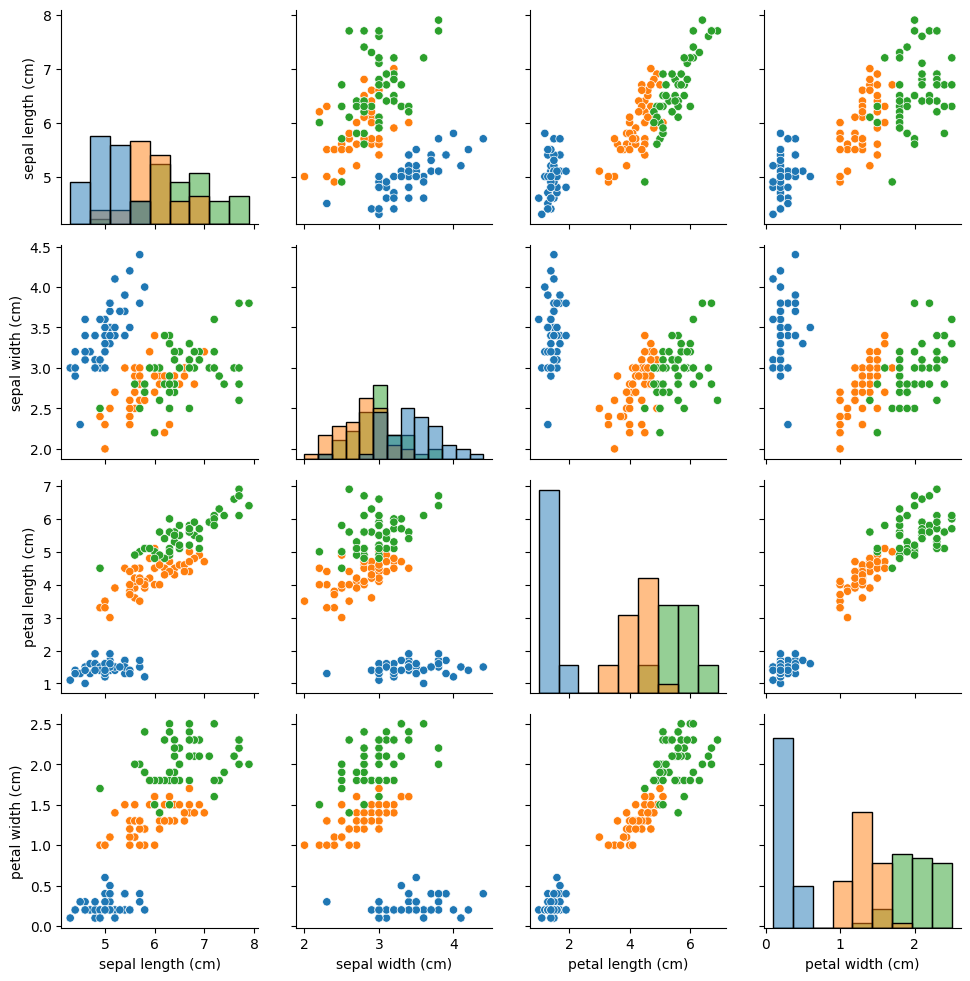

In [7]:
x_vars = df_iris.iloc[:, :4].columns
y_vars = x_vars

g = sns.PairGrid(df_iris, hue = 'target names', x_vars = x_vars, y_vars = y_vars)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

In [8]:
X_iris = iris.data
y_iris = iris.target

### 2. Drzewo z domyślnymi hiperparametrami

In [22]:
def plain_tree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, shuffle = True)
    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    return y_test, y_pred, tree

In [28]:
def print_metrics(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print('\n')
    print(f'Precision: {precision_score(y_test, y_pred, average = "weighted")}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred, average = "weighted")}')
    print(f'F1: {f1_score(y_test, y_pred, average = "weighted")}')

In [26]:
def tree_plot(tree, feature_names, class_names):
    fig = plt.figure(figsize=(25,20))
    _ = plot_tree(tree, 
                   feature_names = feature_names,  
                   class_names = class_names,
                   filled=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.92      0.92      0.92        12
           2       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



Precision: 0.9473684210526315
Accuracy: 0.9473684210526315
Recall: 0.9473684210526315
F1: 0.9473684210526315


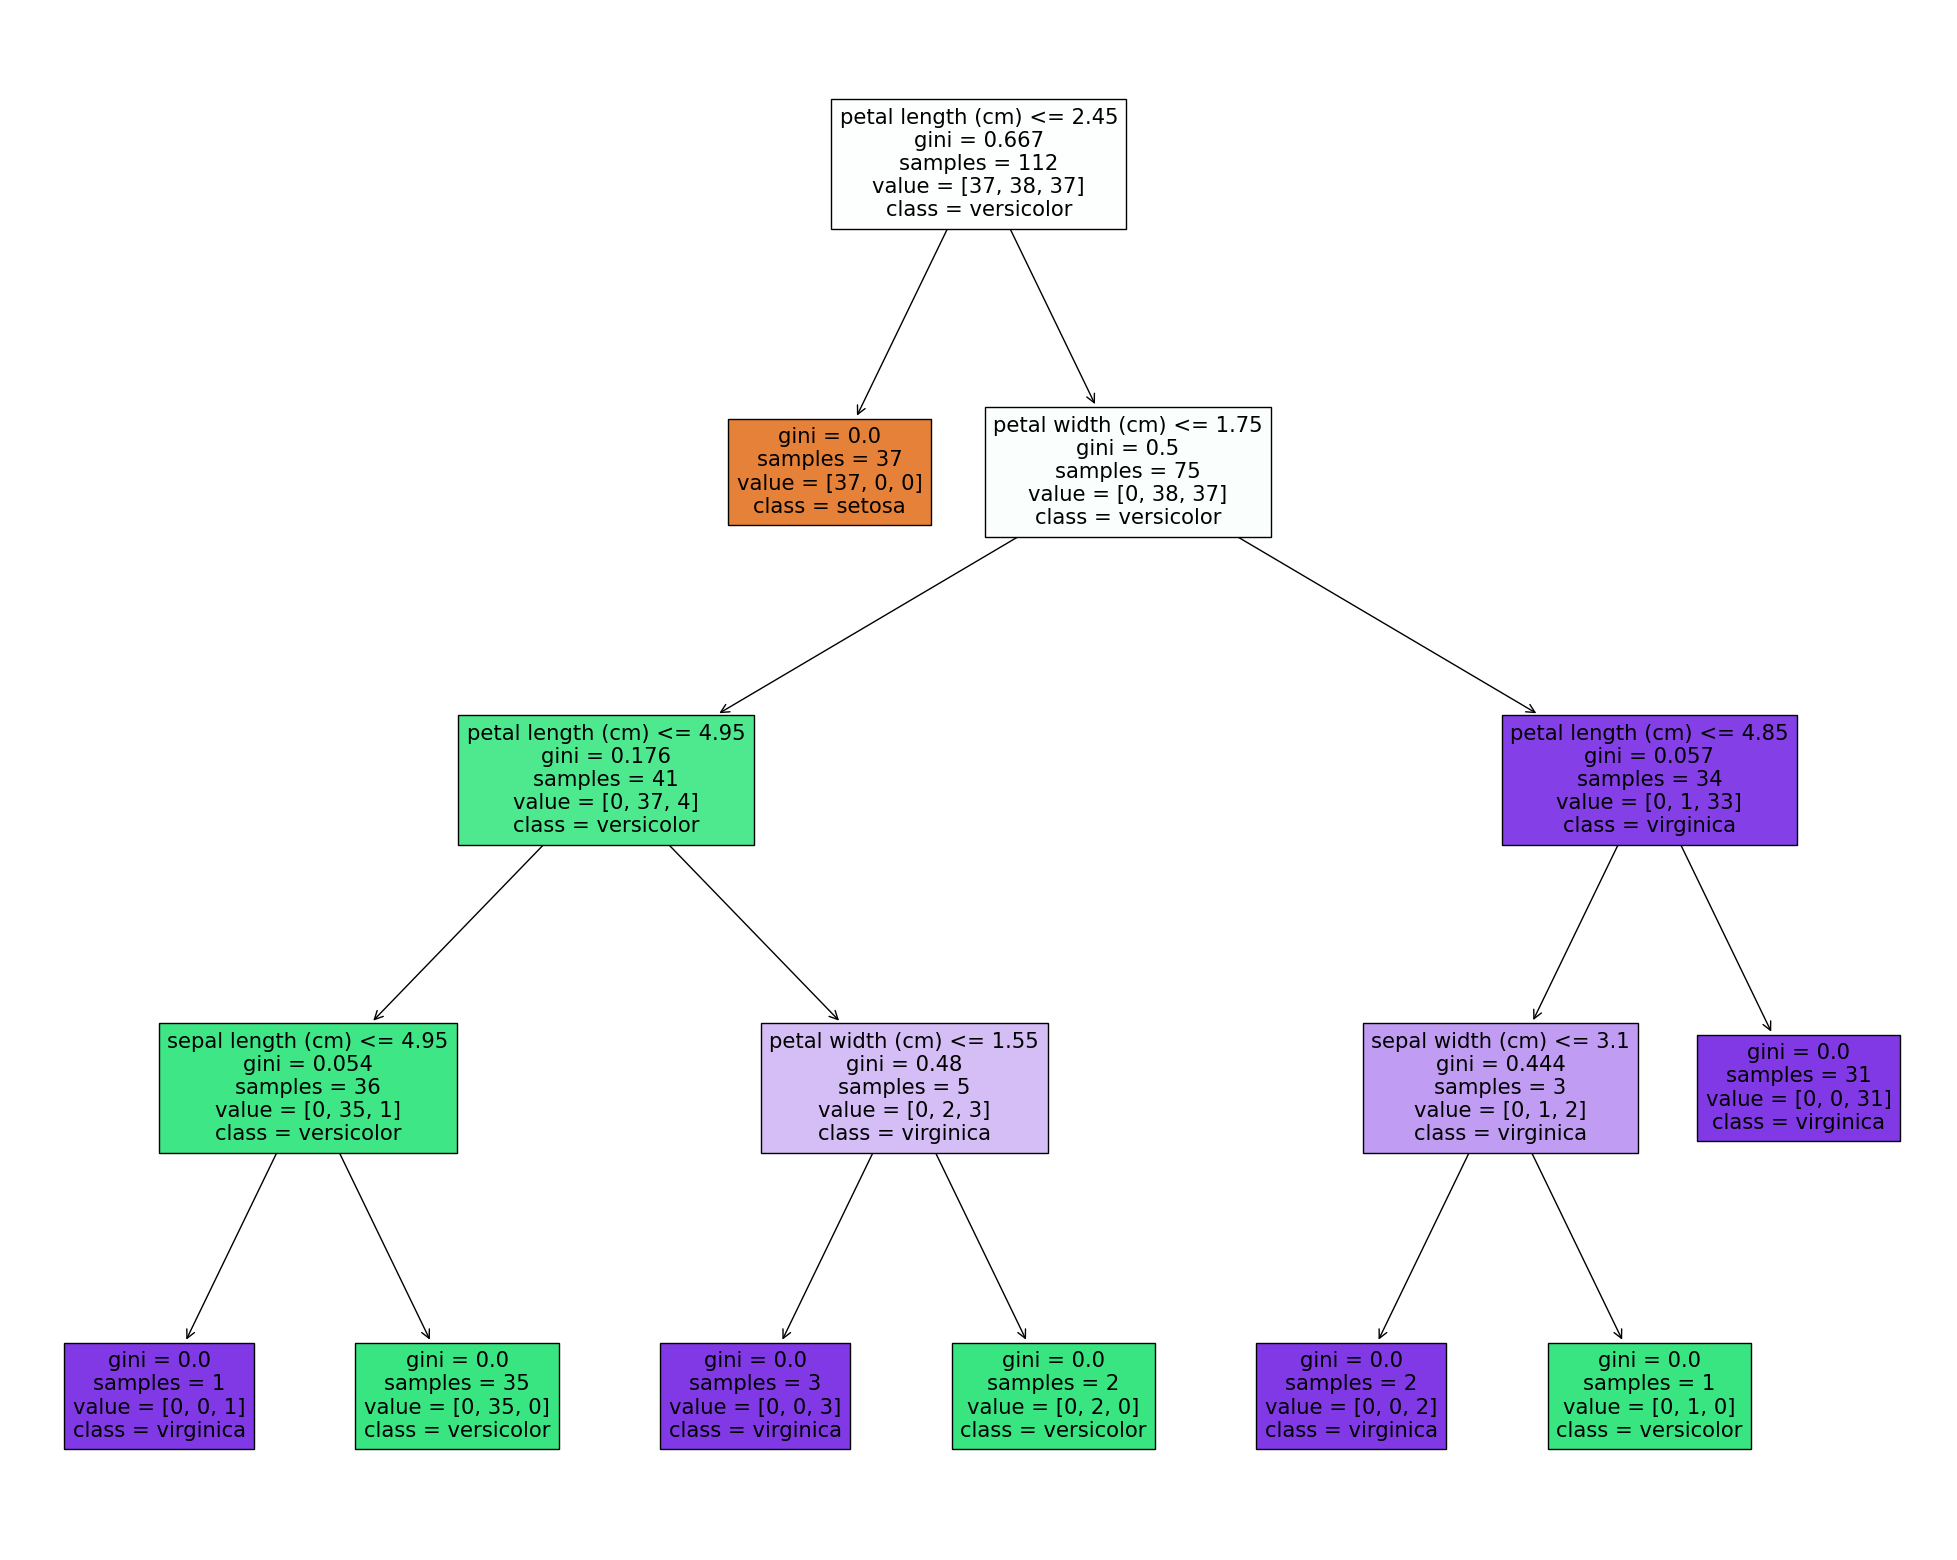

In [29]:
y_test, y_pred, tree = plain_tree(X_iris, y_iris)

print_metrics(y_test, y_pred)
tree_plot(tree, iris.feature_names, iris.target_names)


### 3. Testowanie różnych wartości hiperparametrów

In [34]:
def parametrized_tree(X, y
                      , criterion
                      , max_depth
                      , min_samples_leaf
                    #   , cpp_alpha
                    ):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, shuffle = True)
    tree = DecisionTreeClassifier(criterion = criterion
                      , max_depth = max_depth
                      , min_samples_leaf = min_samples_leaf
                      # , cpp_alpha = cpp_alpha
                      )
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    return y_test, y_pred, tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.87      1.00      0.93        13
           2       1.00      0.85      0.92        13

    accuracy                           0.95        38
   macro avg       0.96      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



Precision: 0.9543859649122807
Accuracy: 0.9473684210526315
Recall: 0.9473684210526315
F1: 0.9470551378446114


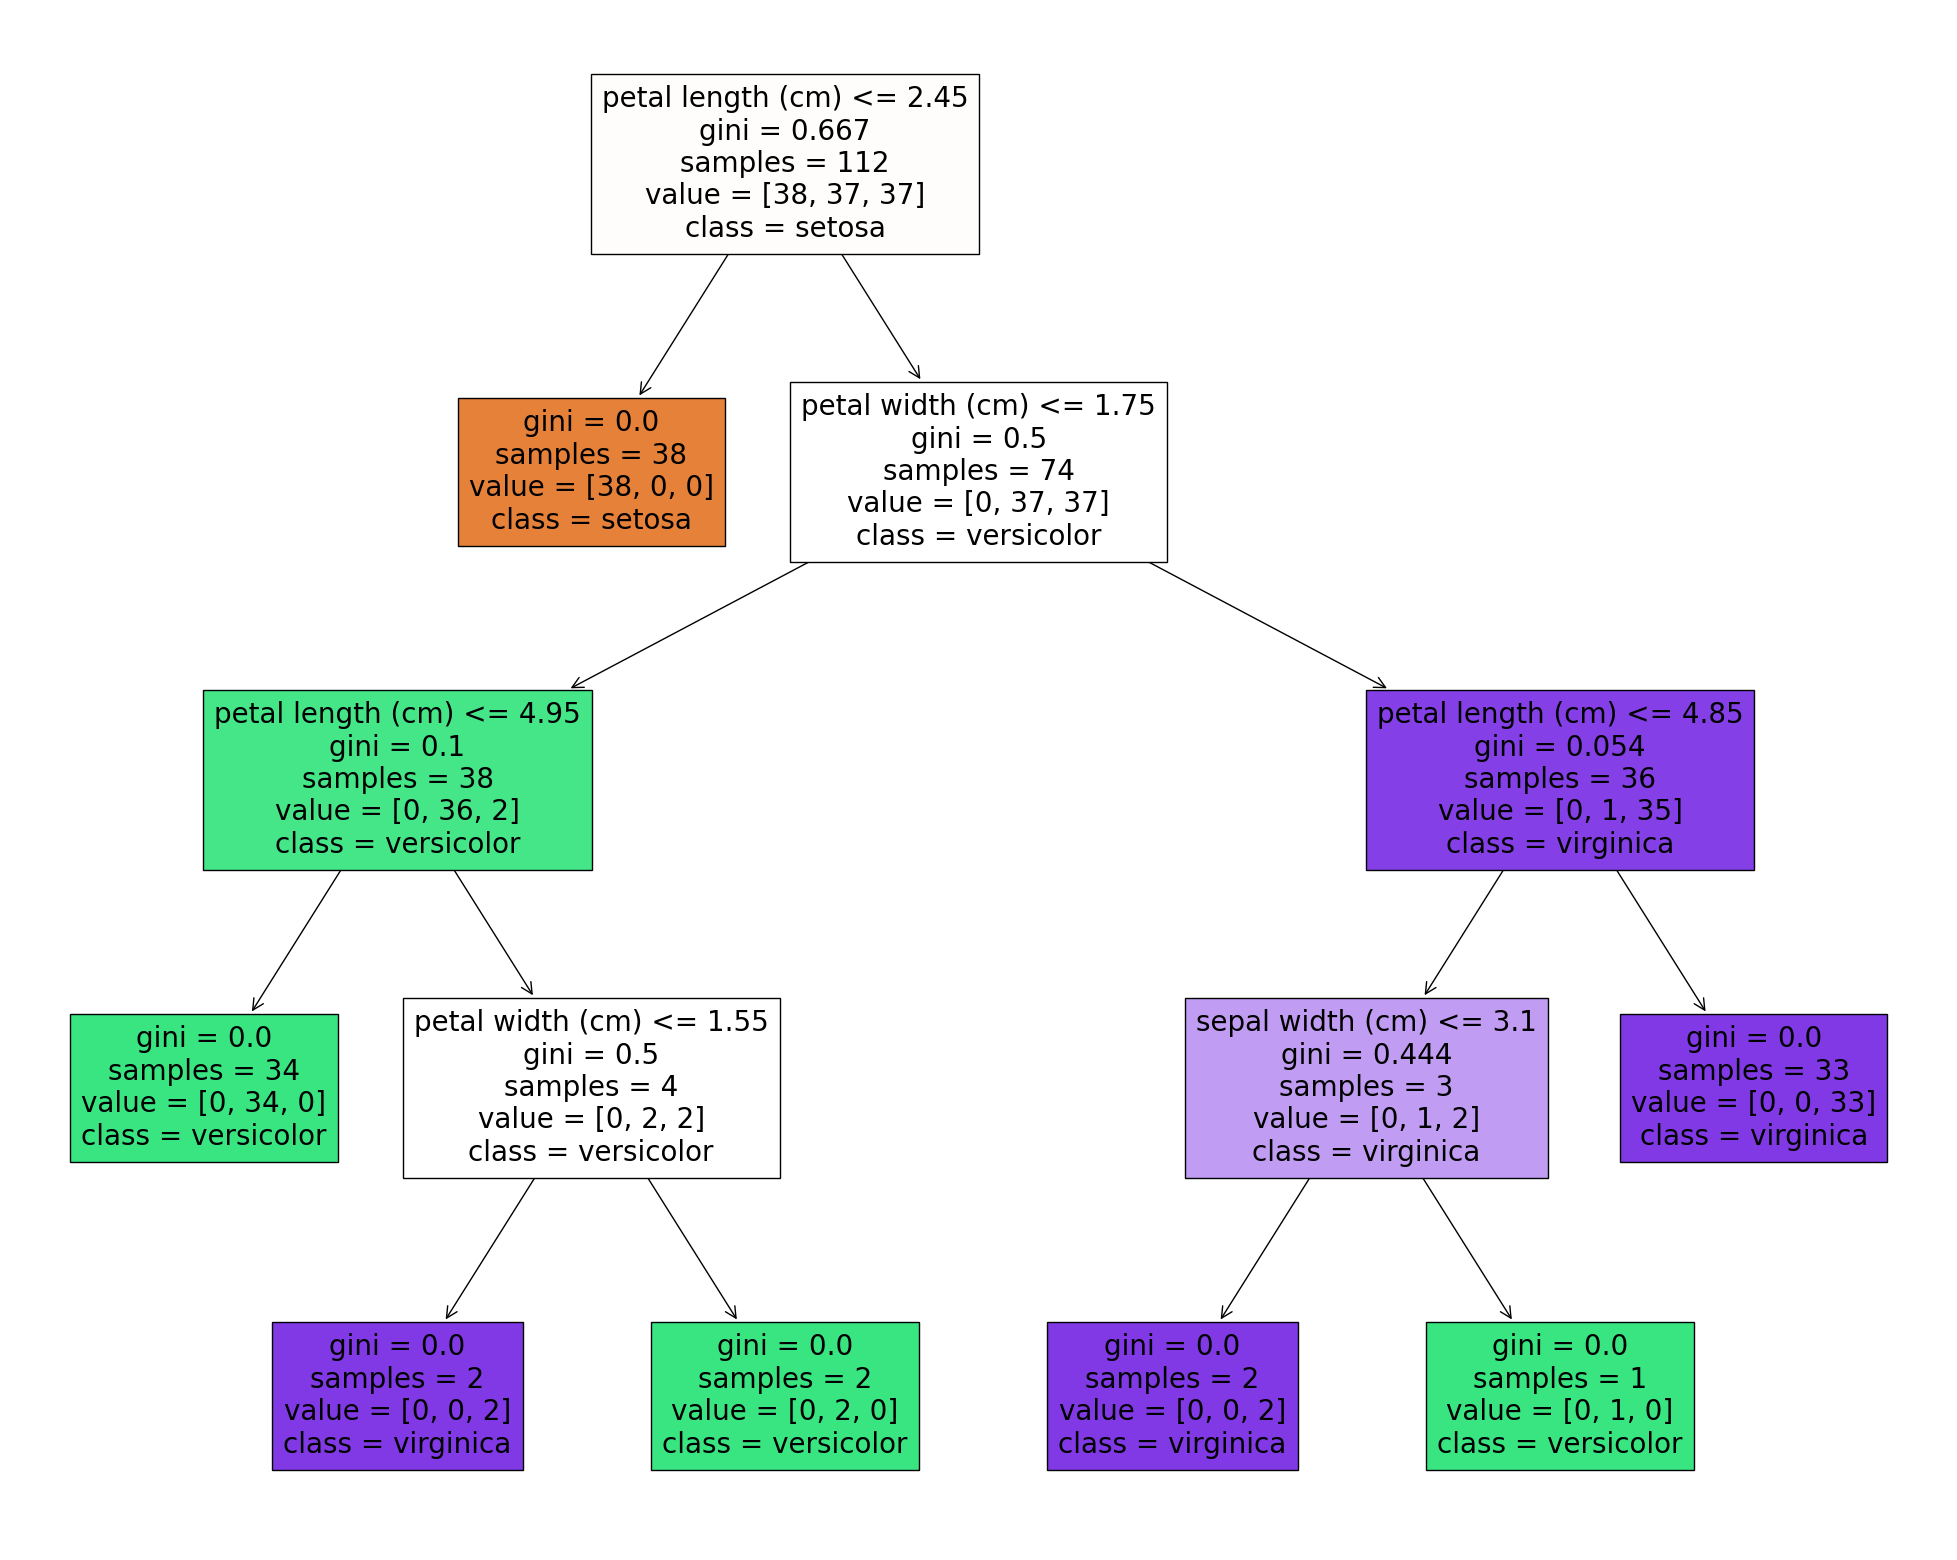

In [39]:
y_test, y_pred, tree = parametrized_tree(X_iris, y_iris
                                         , criterion = 'gini'
                                         , max_depth = 4
                                         , min_samples_leaf = 1)

print_metrics(y_test, y_pred)
tree_plot(tree, iris.feature_names, iris.target_names)


In [ ]:
def best_tree():
    params = {
        'max_depth' : [(i + 1) for i in range(15)]
        , 'criterion' : ['gini', 'entropy']
        , 'min_samples_leaf' : [(i + 1) for i in range(10)]

    param_grid = GridSearchCV
    }

### 4. Walidacja krzyżowa (zwykła i stratyfikowana)

In [ ]:
def cv_tree(n_splits, X, y
            , criterion = 'gini'
            , max_depth = 5
            , min_samples_leaf = 1
           , cv_method = KFold):

    kf = cv_method(n_splits = n_splits, shuffle = shuffle)
    pipe = Pipeline([('normalize', Normalizer()), ('knn', KNeighborsClassifier(n_neighbors = n_neighbors
                                                                               , metric = metric
                                                                               , p = p
                                                                               , metric_params = metric_params
                                                                               , weights = weights))])
    scores = []
    
    if cv_method == KFold:
        splt = kf.split(X)
    elif cv_method == StratifiedKFold:
        splt = kf.split(X, y)
        
    for train_index, test_index in splt:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)

    # Średnia dokładność z k-fold walidacji
    mean_score = np.mean(scores)
    return mean_score